In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

In [6]:
def calcular_fm(img):
    height, width = img.shape[:2]
    # Paso 1: calcular transformada de fourier
    f = np.fft.fft2(img)
    # Paso 2: desplazar el origen/cero al centro
    fc = np.fft.fftshift(f)
    # Paso 3: calcular magnitud
    af = np.abs(fc)
    # Paso 4: calculo el maximo de af
    m = np.max(af)
    # Paso 5: calculo el umbral
    umbral = m/1000
    # Paso 6: calculo la cantidad de pixeles mayores al umbral
    th = np.sum(af > umbral)
    #Paso 7: calculo la calidad de la imagen
    fm = th / (height * width)
    return fm

In [ ]:
def crop_central_region(img, percent):
    """
    Recorta una región central de la imagen según un porcentaje dado.
    
    Args:
        img (np.ndarray): Imagen en formato NumPy (BGR o gris).
        percent (float): Porcentaje (entre 0 y 100) del área total que querés mantener.

    Returns:
        np.ndarray: Recorte central de la imagen.
    """
    if percent <= 0 or percent > 100:
        raise ValueError("percent debe estar entre 0 y 100.")

    h, w = img.shape[:2]
    scale = (percent / 100) ** 0.5  # Escalado sobre alto y ancho (por área)

    crop_h = int(h * scale)
    crop_w = int(w * scale)

    start_y = (h - crop_h) // 2
    start_x = (w - crop_w) // 2

    return img[start_y:start_y + crop_h, start_x:start_x + crop_w]

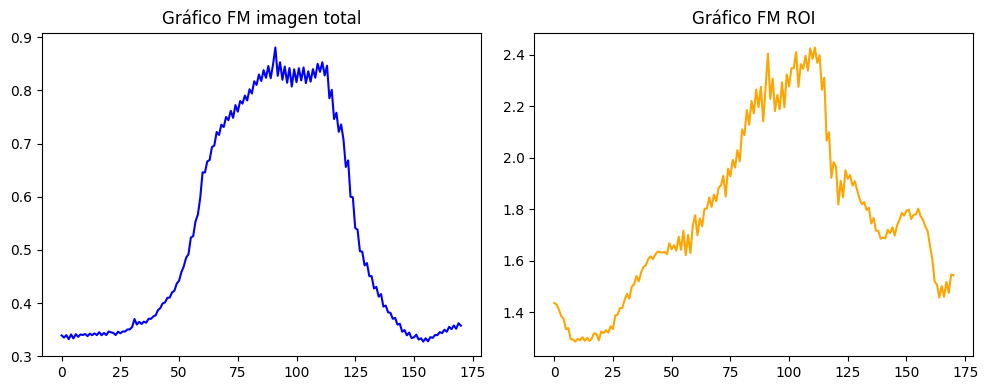

In [ ]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Nuevas dimensiones (mitad del tamaño original)
    half_width = frame_width // 20
    half_height = frame_height // 20
    # Coordenadas de inicio
    start_y = frame_height // 40    
    start_x = frame_width // 40
    
    fm_total_list = []
    fm_roi_list = []

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Calculo el fm del total de la imagen
        fm_total_list.append(calcular_fm(frame))

        # Recorte central
        central_crop = crop_central_region(frame, 10)
        #Calculo el fm del roi
        fm_roi_list.append(calcular_fm(central_crop))


    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].plot(fm_total_list, color='blue')
    axes[0].set_title("Gráfico FM imagen total")

    axes[1].plot(fm_roi_list, color='orange')
    axes[1].set_title("Gráfico FM ROI")

    plt.tight_layout()
    plt.show()

In [4]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Nuevas dimensiones (mitad del tamaño original)
    new_width = frame_width // 2
    new_height = frame_height // 2
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    #fps = 35
    delay = int(600 / fps)
    
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Reducir el tamaño del frame
        frame_resized = cv2.resize(frame, (new_width, new_height))
        
        # Aplicar blur gaussiano al frame reducido
        frame_blur = cv2.GaussianBlur(frame_resized, (15, 15), 1.5)
        
        # Combina el frame original y el frame con blur lado a lado
        frame_combined = np.hstack((frame_resized, frame_blur))

        # Mostrar el frame combinado
        cv2.imshow('Video Original y Blur Gaussiano', frame_combined)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv2.destroyAllWindows()